In [56]:
from differentiable_t1d.dynamics import KanderianMvpParams, KanderianMvpWithGlucoseCompartments, kanderian_mvp
from differentiable_t1d.utils import generate_meals
from differentiable_t1d.controls import square_profile, two_equal_compartment_profile, make_sequential_profile
from differentiable_t1d.controls import BolusParams, BolusController


import jax
import jax.numpy as jnp
import numpy as np
dynamics_params, init_state = kanderian_mvp.initialize_patient(1, to_tensors=False, with_glucose_compartments=True)
jax.config.update("jax_platform_name", "cpu")

In [57]:
dynamics_params

KanderianMvpParams(BW=array(89.), total_daily_insulin=array(50.), ci=array(2010.), tau1=array(49.), tau2=array(47.), tausen=array(10.), vg=array(253.), p2=array(0.0106), egp=array(1.33), gezi=array(0.0022), si=array(0.000811), tau_m=array(4.))

In [68]:
%%time
seed = 0
rng = jax.random.PRNGKey(seed)

t0 = jnp.array(0.)
num_days = 3
t1 = 60. * 24 * num_days # 24 hours in minutes
dt = 1.0  # IMPORTANT: dt must be 1.0 or smaller, or else dynamics won't be accurately integrated
T = int((t1 - t0) / dt) + 1

bolus_params = BolusParams(insulin_carb_ratio=20., correction_factor=35., target_bg=120., prebolus_time=15.)
basal_rate = 0.03 # U/min

meals = generate_meals(bw=dynamics_params.BW.item(), num_days=num_days, seed=0)

meal_times = meals[:, 0]  # minutes
carb_amounts = meals[:, 1]  # g
meal_dose = carb_amounts # g
# convert to mg
meal_dose = meal_dose * 1000.0
# convert to mg/dL
meal_dose = meal_dose / dynamics_params.vg
meal_duration = 1.0 * jnp.ones_like(meal_times)  # assume each meal dose is a spike that lasts 1 minute

def step(t, state, doses):
    bg = KanderianMvpWithGlucoseCompartments.observe_subcutaneous_glucose(dynamics_params, state)[0]
    dose = BolusController.apply(bolus_params, meal_times, carb_amounts, t, dt, bg)
    doses = jnp.concatenate([doses, jnp.array([[t, dose]])], axis=0)

    # meal computations doesn't change so we can compute it outside of the loop
    meal_profile = make_sequential_profile(square_profile, (meal_dose, meal_duration), meal_times)

    insulin_times = doses[:, 0]
    insulin_duration = 1.0 * jnp.ones_like(insulin_times)  # assume each insulin bolus dose is a spike that lasts 1 minute
    insulin_doses = doses[:, 1]  # total insulin in Units
    insulin_profile = make_sequential_profile(square_profile, (insulin_doses, insulin_duration), insulin_times)

    # compute meal and insulin rate curves
    carbs = meal_profile(t)  # profile takes care of converting mg/dL to mg/dL/min
    insulin = insulin_profile(t)  # U/min; profile takes care of converting U to U/min

    # add basal dose; more generally, we could instead have another control function for basal dosing
    insulin = insulin + basal_rate

    # convert U to an insulin delivery rate muU / mL / min
    insulin = insulin * 1e6 / dynamics_params.ci / dynamics_params.tau1
    dstate_dt, _ = KanderianMvpWithGlucoseCompartments.dynamics(dynamics_params, t, state, carbs, insulin)
    state = state + dstate_dt * dt + jax.random.normal(jax.random.fold_in(rng, t), shape=state.shape) * jnp.sqrt(dt) * init_state / 100

    # save the controls
    u_insulin = jnp.array([insulin])
    u_carbs = jnp.array([carbs])

    return state, dose, doses, u_insulin, u_carbs

def step_wrapped(carry, i):
    state, doses = carry
    t = t0 + i * dt
    state, dose, doses, u_insulin, u_carbs = step(t, state, doses)
    return (state, jax.lax.slice_in_dim(doses, doses.shape[0] - k, doses.shape[0])), (t, dose, u_insulin, u_carbs, state)

k = int(4 * 60. / dt) # jax.jit requires a fixed shape input to avoid recompilation
doses_arr = jnp.zeros((k, 2))

init_carry = (init_state, doses_arr)
timesteps = jnp.arange(1, T)
_, (ts, doses, u_insulin, u_carbs, states) = jax.lax.scan(step_wrapped, init_carry, timesteps)

states = jnp.concatenate([init_state[None, :], states], axis=0)
ts = jnp.concatenate([jnp.array([t0]), ts], axis=0)
doses = jnp.concatenate([jnp.zeros((1,)), doses], axis=0)
u_insulin = jnp.concatenate([basal_rate * 1e6 / dynamics_params.ci / dynamics_params.tau1 * jnp.ones((1, 1)), u_insulin], axis=0)[:, 0]
u_carbs = jnp.concatenate([jnp.zeros((1, 1)), u_carbs], axis=0)[:, 0]

CPU times: user 333 ms, sys: 230 µs, total: 333 ms
Wall time: 328 ms


In [69]:
G, Ieff, Isc, Ip, Gisf, G1, G2 = states.T

In [70]:
state_size = states.shape[1]

[Text(0, 0.5, 'G2')]

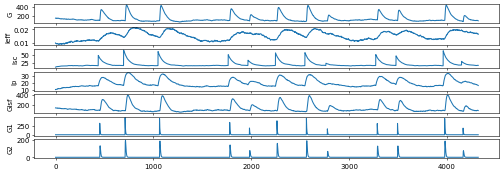

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(state_size, figsize=(12, 4), dpi=50)
ax = ax.flatten()
ax[0].plot(G)
ax[0].set(ylabel="G")
ax[1].plot(Ieff)
ax[1].set(ylabel="Ieff")
ax[2].plot(Isc)
ax[2].set(ylabel="Isc")
ax[3].plot(Ip)
ax[3].set(ylabel="Ip")
ax[4].plot(Gisf)
ax[4].set(ylabel="Gisf")
ax[5].plot(G1)
ax[5].set(ylabel="G1")
ax[6].plot(G2)
ax[6].set(ylabel="G2")

[Text(0.5, 0, 'Time (hr)'), Text(0, 0.5, 'Glucose (mg/dL)')]

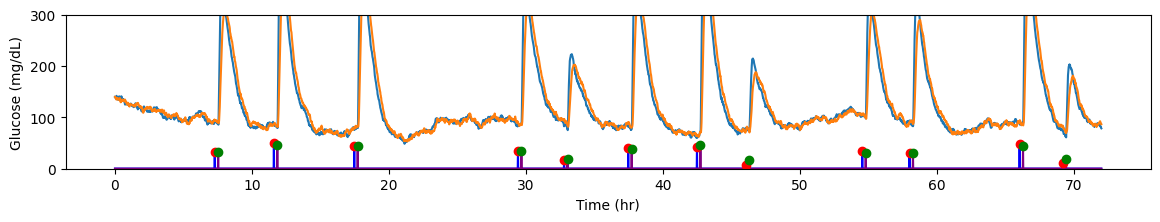

In [72]:
nonzero = doses.nonzero()[0]
insulin_doses = doses[nonzero]
insulin_times = ts[nonzero]


fig, ax = plt.subplots(1, 1, figsize=(14, 2))
t = np.arange(T) * dt
G = KanderianMvpWithGlucoseCompartments.observe_blood_glucose(dynamics_params, states)[:, 0]
Gs = KanderianMvpWithGlucoseCompartments.observe_subcutaneous_glucose(dynamics_params, states)[:, 0]
ax.plot(t / 60, G)
ax.plot(t / 60, Gs)
ax.plot(t / 60, u_insulin * 1.0, color="blue")
ax.plot(t / 60, u_carbs * 0.1, color="purple")
ax.plot(insulin_times / 60, insulin_doses * 10, 'o', color="red")
ax.plot(meal_times / 60, meal_dose * 0.1, 'o', color="green")
ax.set(ylim=[0, 300])
ax.set(xlabel="Time (hr)", ylabel="Glucose (mg/dL)")

In [73]:
def subsample(x, every=1):
    return x[::every]

def ar_process(rng, length, weights=[0.9], noise_std=1.0):
    # 1D AR process
    p = len(weights)
    weights = jnp.array(weights)
    white_noise = jax.random.normal(rng, (length,)) * noise_std
    def step(prev, noise):
        curr = jnp.tensordot(weights, prev, 1) + noise
        prev = jnp.concatenate([prev[1:], curr[None]])
        return prev, curr
    _, x = jax.lax.scan(step, jnp.zeros((p,)), white_noise)
    return x

In [158]:
def subsample_by_mean(x, every=1):
    # subsample by averaging entries of indices that fall into the same bin
    # this is the right way to average controls if x are the controls and the controls are rates and `x` is evenly spaced in time (i.e. have units of 1/time)
    # pad to nearest multiple of `every`
    if x.shape[0] % every != 0:
        x = jnp.pad(x, ((0, every - x.shape[0] % every),) + ((0, 0),)*(x.ndim - 1), mode="edge")
    x = x.reshape(-1,  every, *x.shape[1:])
    return jnp.mean(x, axis=1)

In [159]:
subsample_factor = 5
Gs_subsampled = subsample_by_mean(Gs, every=subsample_factor)
ts_subsampled = subsample(ts, every=subsample_factor)
u_insulin_subsampled = subsample_by_mean(u_insulin, every=subsample_factor)  # make sure we don't subsample away the controls; get average rate over bin
u_carbs_subsampled = subsample_by_mean(u_carbs, every=subsample_factor)
states_subsampled = subsample_by_mean(states, every=subsample_factor)

#Gs_subsampled_noisy = ar_process(rng, Gs_subsampled.shape[0], weights=[0.9], noise_std=5.0) + Gs_subsampled
Gs_subsampled_noisy = Gs_subsampled

[Text(0.5, 0, 'Time (hr)'), Text(0, 0.5, 'Glucose (mg/dL)')]

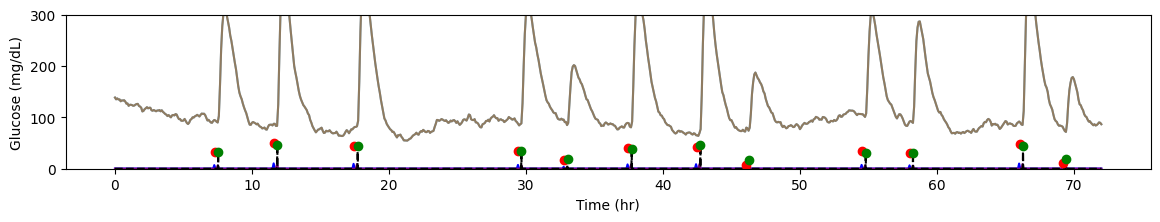

In [160]:
fig, ax = plt.subplots(figsize=(14, 2))
ax.plot(ts_subsampled / 60, Gs_subsampled_noisy)
ax.plot(ts_subsampled / 60, Gs_subsampled, alpha=0.5)
ax.set(ylim=[0, 300])
ax.plot(ts_subsampled / 60, u_insulin_subsampled * 1.0, color="blue")
ax.plot(ts_subsampled / 60, u_carbs_subsampled * 0.1, color="purple")
ax.plot(ts / 60, u_carbs * 0.1, color="black", ls='--')  # check that subsampling is correct
ax.plot(insulin_times / 60, insulin_doses * 10, 'o', color="red")
ax.plot(meal_times / 60, meal_dose * 0.1, 'o', color="green")
ax.set(ylim=[0, 300])
ax.set(xlabel="Time (hr)", ylabel="Glucose (mg/dL)")

[Text(0.5, 0, 'Glucose (mg/dL)'), Text(0, 0.5, 'Probability')]

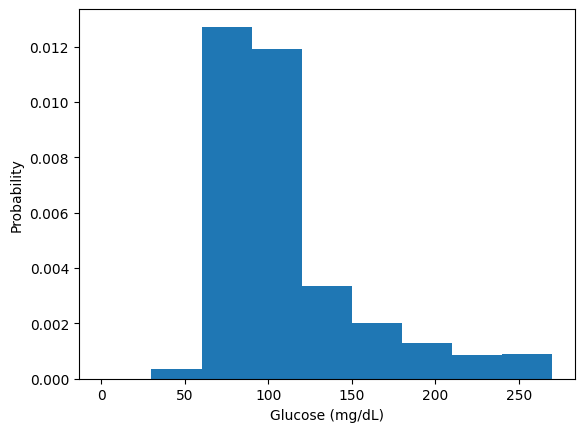

In [161]:
fig, ax = plt.subplots()
ax.hist(Gs, bins=np.arange(10) * 30, density=True)
ax.set(xlabel="Glucose (mg/dL)", ylabel="Probability")

In [162]:
def make_A(params, state, dt):
    assert state.ndim == 1
    G = state[0]
    state = jnp.clip(state, a_min=0.0)  # clamp to avoid negative values
    # Jacobian of the dynamics function
    dstate = jnp.array([
     [-params.gezi, -G, 0, 0, 0, 0, 1/params.tau_m],
     [0, -params.p2, 0, params.p2 * params.si, 0, 0, 0],
     [0, 0, -1/params.tau1, 0, 0, 0, 0],
     [0, 0, 1/params.tau2, -1/params.tau2, 0, 0, 0],
     [1/params.tausen, 0, 0, 0, -1/params.tausen, 0, 0],
     [0, 0, 0, 0, 0, -1/params.tau_m, 0],
     [0, 0, 0, 0, 0, 1/params.tau_m, -1/params.tau_m],
    ])
    A = jnp.eye(state.shape[-1]) + dstate * dt
    return A

def make_bias(params, carbs, insulin):
    return jnp.array([params.egp, 0, insulin, 0, 0, carbs, 0])

In [163]:
def kalman_dot(x, Vp, C, R):
    assert x.ndim == 1
    VpCT = jnp.dot(Vp, C.T)
    R_CVCT = R + jnp.dot(C, VpCT)
    R_CVCT_inv_array = jax.scipy.linalg.solve(R_CVCT, x, assume_a="pos")
    K_array = jnp.dot(VpCT, R_CVCT_inv_array)
    return K_array

def predict(params, prev_mf_biased, prev_Vf, Q, bias, dt, num_iters=1):
    assert prev_mf_biased.ndim == 1
    assert bias.ndim == 1

    def _predict(prev_mf_biased, prev_Vf):
        A = make_A(params, prev_mf_biased, dt)  # Approximation: estimate A using best guess of previous state
        mp_unbiased = jnp.dot(A, prev_mf_biased)
        mp_biased = mp_unbiased + bias
        Vp = jnp.dot(A, jnp.dot(prev_Vf, A.T)) + Q
        return mp_biased, Vp
    
    def step(carry, _):
        prev_mf_biased, prev_Vf = carry
        mp_biased, Vp = _predict(prev_mf_biased, prev_Vf)
        return (mp_biased, Vp), None 

    (mp_biased, Vp), _ = jax.lax.scan(step, (prev_mf_biased, prev_Vf), None, length=num_iters)
    return mp_biased, Vp

def update(mp_biased, Vp, y, C, R):
    assert mp_biased.ndim == 1
    assert y.ndim == 1
    pred_err = y - jnp.dot(C, mp_biased)
    kalman_update = kalman_dot(pred_err, Vp, C, R)
    mf_biased = mp_biased + kalman_update    
    Vf = Vp - jax.vmap(kalman_dot, (1, None, None, None))(jnp.dot(C, Vp), Vp, C, R)
    return mf_biased, Vf, kalman_update

def filtering_pass(params, y, m0_biased, V0, C, R, Q, bias_seq, dt, data_dt):
    assert y.ndim == 2
    assert m0_biased.ndim == 1
    assert bias_seq.ndim == 2

    num_iters = int(data_dt / dt)  # number of euler steps between observations

    def step(carry, curr):
        prev_mf_biased, prev_Vf = carry
        y, bias = curr
        mp_biased, Vp = predict(params, prev_mf_biased, prev_Vf, Q, bias, dt, num_iters=num_iters)
        mf_biased, Vf, kalman_update = update(mp_biased, Vp, y, C, R)
        carry = (mf_biased, Vf)
        return carry, (mp_biased, Vp, mf_biased, Vf, kalman_update)

    mf_biased, Vf, _ = update(mp_biased=m0_biased, Vp=V0, y=y[0], C=C, R=R)
    init = (mf_biased, Vf)
    carry, (mp_biased, Vp, mf_biased, Vf, kalman_update) = jax.lax.scan(step, init, (y[1:], bias_seq[1:]))
    return init, mp_biased, Vp, mf_biased, Vf, kalman_update

def predict_pass(params, num_preds, m0_biased, V0, C, R, Q, bias_seq, dt, data_dt):
    assert m0_biased.ndim == 1
    assert bias_seq.ndim == 2

    num_iters = int(data_dt / dt)  # number of euler steps between observations

    def step(carry, curr):
        prev_mf_biased, prev_Vf = carry
        bias = curr
        mp_biased, Vp = predict(params, prev_mf_biased, prev_Vf, Q, bias, dt, num_iters=num_iters)
        carry = (mp_biased, Vp)
        return carry, (mp_biased, Vp)

    init = (m0_biased, V0)
    carry, (mp_biased, Vp) = jax.lax.scan(step, init, bias_seq[1:], length=num_preds)
    return init, mp_biased, Vp

def smoothing_pass(params, mf_biased, Vf, C, R, Q, bias_seq, dt, data_dt):
    assert mf_biased.ndim == 2
    assert Vf.ndim == 3
    assert bias_seq.ndim == 2

    num_iters = int(data_dt / dt)  # number of euler steps between observations

    def step(carry, curr):
        next_ms_biased, next_Vs = carry
        mf_biased, Vf, bias = curr
        pred_ms_biased, pred_Vs = predict(params, mf_biased, Vf, Q, bias, dt, num_iters=num_iters)

        ms_biased = mf_biased
    # TODO: how to make this work with missing observations/continuous time?
    pass

In [190]:
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_disable_jit", False)
jax.config.update('jax_default_matmul_precision', 'float32')

filtering_dt = 1.0

def add_noise(rng, x, relative_noise=1.0):
    return x * jnp.exp(jax.random.normal(rng, shape=x.shape) * relative_noise)

def rng_like(rng, pytree):
    treedef = jax.tree_util.tree_structure(pytree)
    keys = jax.random.split(rng, treedef.num_leaves)
    return jax.tree_util.tree_unflatten(treedef, keys)

noisy_dynamics_params = jax.tree_map(lambda rng, x: add_noise(rng, x, relative_noise=0.), rng_like(jax.random.PRNGKey(17), dynamics_params), dynamics_params)
#noisy_u_carbs_subsampled = u_carbs_subsampled * jnp.exp(ar_process(jax.random.PRNGKey(1), u_carbs_subsampled.shape[0], weights=[0.9], noise_std=0.2))
noisy_u_carbs_subsampled = u_carbs_subsampled * jnp.exp(ar_process(jax.random.PRNGKey(1), u_carbs_subsampled.shape[0], weights=[0.9], noise_std=0.))
#noisy_u_insulin_subsampled = u_insulin_subsampled * jnp.exp(ar_process(jax.random.PRNGKey(2), u_insulin_subsampled.shape[0], weights=[0.9], noise_std=0.2))
noisy_u_insulin_subsampled = u_insulin_subsampled * jnp.exp(ar_process(jax.random.PRNGKey(2), u_insulin_subsampled.shape[0], weights=[0.9], noise_std=0.))
# systematic offset in controls by rolling by one timestep (dt)
#noisy_u_carbs_subsampled = jnp.roll(noisy_u_carbs_subsampled, shift=1)
#noisy_u_insulin_subsampled = jnp.roll(noisy_u_insulin_subsampled, shift=1)
# randomly missing controls
noisy_u_carbs_subsampled = jax.random.bernoulli(jax.random.PRNGKey(3), p=0.75, shape=noisy_u_carbs_subsampled.shape) * noisy_u_carbs_subsampled
noisy_u_insulin_subsampled = jax.random.bernoulli(jax.random.PRNGKey(4), p=0.75, shape=noisy_u_insulin_subsampled.shape) * noisy_u_insulin_subsampled


bias_seq = jax.vmap(make_bias, (None, 0, 0))(noisy_dynamics_params,
    noisy_u_carbs_subsampled,
    noisy_u_insulin_subsampled,
)
y = Gs_subsampled_noisy.reshape(-1, 1)  # ensure 2D
#m0_biased = jnp.clip(init_state + init_state * jax.random.normal(jax.random.PRNGKey(0), shape=init_state.shape), a_min=0.0)
#V0 = jnp.diag(jnp.sqrt(init_state))  # initial uncertainty 
m0_biased = states_subsampled.mean(0)  # initialize with mean that we roughly know from simulators
V0 = jnp.diag(states_subsampled.std(0) ** 2)  # same with the marignal variances
limit_T = len(Gs_subsampled)
#limit_T = int(4 * 60 / filtering_dt)
y = y[:limit_T]
bias_seq = bias_seq[:limit_T]
ts_limited = ts_subsampled[:limit_T]

C = jnp.array([[0., 0., 0., 0., 1.0, 0., 0.]])  # observe subcutaneous glucose
#R = (3 * (Gs_subsampled_noisy - Gs_subsampled).std(0).reshape(-1, 1)) ** 2  # observation noise
R = (Gs_subsampled_noisy.std(0) / 1).reshape(-1, 1) ** 2  # observation noise
Q = V0 * filtering_dt * filtering_dt / (ts_limited[-1] - ts_limited[0])  # transition noise; NOTE: if transition noise too big, Vp will accumulate (repeated adding Q) and blow up
#Q = V0 * 0.

init, mp_biased, Vp, mf_biased, Vf, kalman_update = filtering_pass(noisy_dynamics_params, y, m0_biased, V0, C, R, Q, bias_seq, dt=filtering_dt, data_dt=dt * subsample_factor)
mp_biased = jnp.vstack([m0_biased, mp_biased])
Vp = jnp.concatenate([V0[None], Vp])
mf_biased = jnp.vstack([init[0], mf_biased])
Vf = jnp.concatenate([init[1][None], Vf])

yp = jnp.dot(mp_biased, C.T)
yf = jnp.dot(mf_biased, C.T)

init, mp_biased_no_f, Vp_no_f = predict_pass(noisy_dynamics_params, len(y) - 1, m0_biased, V0, C, R, Q, bias_seq, dt=filtering_dt, data_dt=dt * subsample_factor)
mp_biased_no_f = jnp.vstack([m0_biased, mp_biased_no_f])
Vp_no_f = jnp.concatenate([V0[None], Vp_no_f])
yp_no_f = jnp.dot(mp_biased_no_f, C.T)

In [191]:
# check relative error of dynamics parameters
jax.tree_util.tree_map(lambda a, b: jnp.abs(a - b)/(jnp.abs(a + b)/2), noisy_dynamics_params, dynamics_params)

KanderianMvpParams(BW=Array(0., dtype=float32), total_daily_insulin=Array(0., dtype=float32), ci=Array(0., dtype=float32), tau1=Array(0., dtype=float32), tau2=Array(0., dtype=float32), tausen=Array(0., dtype=float32), vg=Array(0., dtype=float32), p2=Array(0., dtype=float32), egp=Array(0., dtype=float32), gezi=Array(0., dtype=float32), si=Array(0., dtype=float32), tau_m=Array(0., dtype=float32))

Setup:
- Extended Kalman filter (not terrible because the dynamics are only mildly nonlinear)
- Subsample observations and controls to be every 5th timestep of generative process
- ~10% Misspecified dynamics parameters
- Observation with AR noise
- Controls with AR noise
- Kalman updates in between observation timestamps
- Stochastic transitions (better recovers from the misspecified dynamics compared to deterministic transitions)
- No learning (dynamics, stochasticities, observation noise all hand-specified)

Assumes:
- Know the entire additive control sequence

In [192]:
A = make_A(noisy_dynamics_params, m0_biased, filtering_dt)
A
# notice that the eigenvalues of A oscillates around ~< 1 so that dynamics don't blow up
# this explains why the predictive variances don't blow up as we make longer predictions

Array([[ 9.9779999e-01, -1.2707525e+02,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  2.5000000e-01],
       [ 0.0000000e+00,  9.8940003e-01,  0.0000000e+00,  8.5965994e-06,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  9.7959185e-01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  2.1276595e-02,  9.7872341e-01,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         8.9999998e-01,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  7.5000000e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  2.5000000e-01,  7.5000000e-01]], dtype=float32)

In [193]:
A - jnp.eye(A.shape[0])

Array([[-2.20000744e-03, -1.27075249e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.50000000e-01],
       [ 0.00000000e+00, -1.05999708e-02,  0.00000000e+00,
         8.59659940e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.04081535e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.12765951e-02,
        -2.12765932e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000024e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.50000000e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.50000000e-01,
        -2.5000000

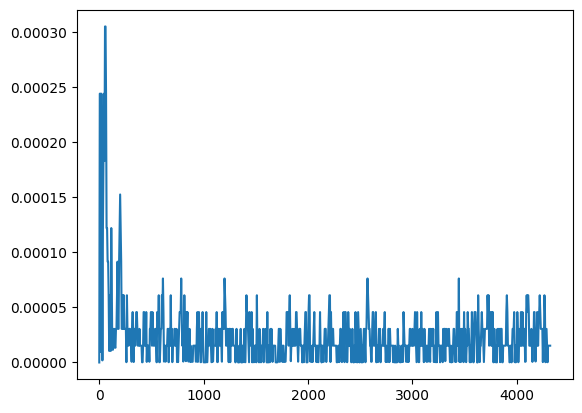

In [194]:
plt.plot(ts_limited, jnp.abs(Vp - Vp.transpose((0, 2, 1))).max(axis=(1, 2)))

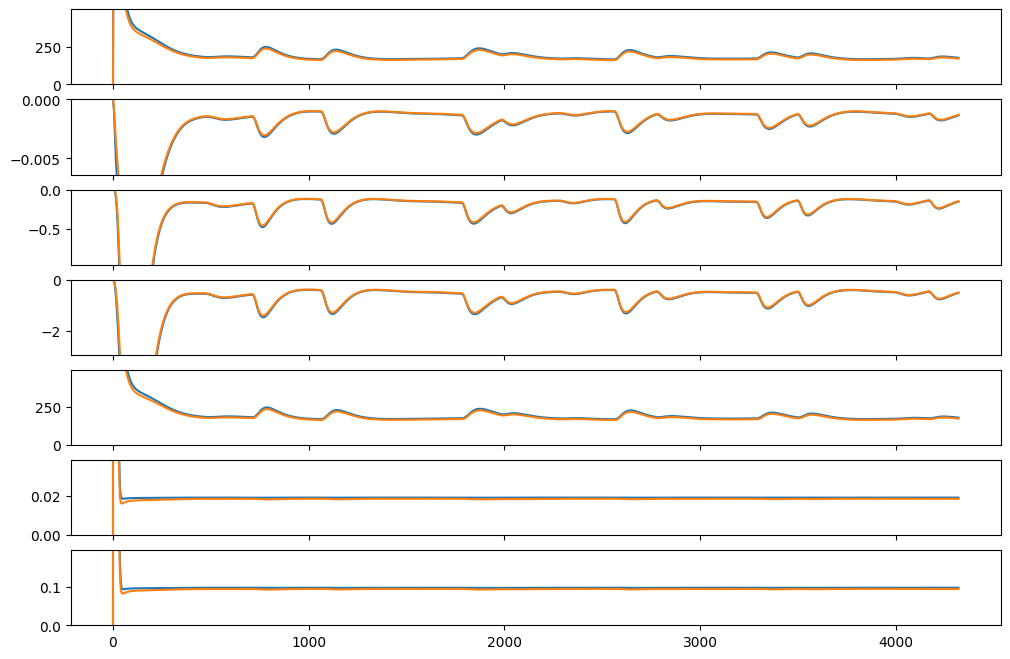

In [195]:
fig, axes = plt.subplots(nrows=len(init_state), sharex=True, figsize=(12, 8))
for i, ax in enumerate(axes):
    ax.plot(ts_limited[:], Vp[:, i, 4], label='Vp')
    ax.plot(ts_limited[:], Vf[:, i, 4], label='Vf')
    ax.set(ylim=[min(0, 2 * Vp[100:, i, 4].min()), max(0, 2 * Vp[100:, i, 4].max())])

In [196]:
dynamics_params.gezi

array(0.0022)

[Text(0.5, 0, 'time (min)')]

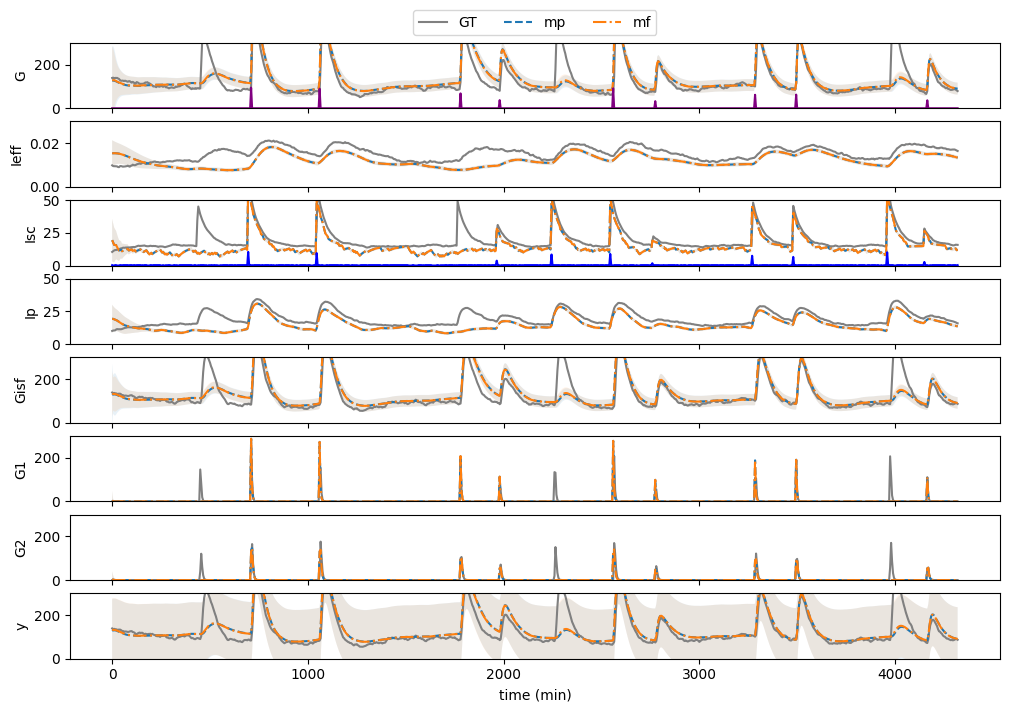

In [197]:
# add 1 for observation plot
fig, axes = plt.subplots(nrows=len(init_state) + 1, sharex=True, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()[:len(init_state)]):
    ax.plot(ts_limited, states_subsampled[:len(y), i], label="GT", c='gray', ls='-')

    ax.plot(ts_limited, mp_biased[:, i], label="mp", ls='--')
    ax.fill_between(ts_limited, mp_biased[:, i] - 2 * jnp.sqrt(Vp[:, i, i]), mp_biased[:, i] + 2 * jnp.sqrt(Vp[:, i, i]), alpha=0.1)

    ax.plot(ts_limited, mf_biased[:, i], label="mf", ls='-.')
    ax.fill_between(ts_limited, mf_biased[:, i] - 2 * jnp.sqrt(Vf[:, i, i]), mf_biased[:, i] + 2 * jnp.sqrt(Vf[:, i, i]), alpha=0.1)

    #ax.plot(ts_limited, mp_biased_no_f[:, i], label="mp_no_f", ls=':')
    #ax.fill_between(ts_limited, mp_biased_no_f[:, i] - 2 * jnp.sqrt(Vp_no_f[:, i, i]), mp_biased_no_f[:, i] + 2 * jnp.sqrt(Vp_no_f[:, i, i]), alpha=0.1)

    ax.set(ylabel=f"state {i}")

# move legend to the center above axes
axes[0].legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', borderaxespad=0., ncol=4)

axes[0].plot(ts_limited, noisy_u_carbs_subsampled[:limit_T] * 1, c="purple")
axes[0].set(ylim=[0, 300], ylabel="G")

axes[1].set(ylim=[0, 0.03], ylabel="Ieff")

axes[2].plot(ts_limited, noisy_u_insulin_subsampled[:limit_T] * 1., c="blue")
axes[2].set(ylim=[0, 50], ylabel="Isc")

axes[3].set(ylim=[0, 50], ylabel="Ip")

axes[4].set(ylim=[0, 300], ylabel="Gisf")
axes[5].set(ylim=[0, 300], ylabel="G1")
axes[6].set(ylim=[0, 300], ylabel="G2")

axes[7].plot(ts_limited, y[:, 0], c="gray")
axes[7].plot(ts_limited, yp[:, 0], ls='--')
axes[7].fill_between(ts_limited, yp[:, 0] - 2 * jnp.sqrt(R[0, 0]), yp[:, 0] + 2 * jnp.sqrt(R[0, 0]), alpha=0.1)
axes[7].plot(ts_limited, yf[:, 0], ls='-.')
axes[7].fill_between(ts_limited, yf[:, 0] - 2 * jnp.sqrt(R[0, 0]), yf[:, 0] + 2 * jnp.sqrt(R[0, 0]), alpha=0.1)
#axes[7].plot(ts_limited, yp_no_f[:, 0], ls=':')
#axes[7].fill_between(ts_limited, yp_no_f[:, 0] - 2 * jnp.sqrt(R[0, 0]), yp_no_f[:, 0] + 2 * jnp.sqrt(R[0, 0]), alpha=0.1)
axes[7].set(ylabel="y", ylim=[0, 300])
axes[7].set(xlabel="time (min)")

\begin{align}
\frac{d}{dt} \begin{bmatrix}G \\ I_{eff}\\ I_{sc}\\ I_p\\ G_{isf} \\ G_1 \\ G_2 \end{bmatrix} &=
\begin{bmatrix}
-GEZI & -G(t) & 0 & 0 & 0 & 0 & 1/\tau_m\\
0 & -p_2 & 0 & p_2\cdot S_i & 0 & 0 & 0\\
0 & 0 & -1/\tau_1 & 0 & 0 & 0 & 0\\
0 & 0 & 1/\tau_1 & -1/\tau_2 & 0 & 0 & 0\\
1/\tau_s & 0 & 0 & 0 & -1/\tau_s & 0 & 0\\
0 & 0 & 0 & 0 & 0 & -1/\tau_m & 0\\
0 & 0 & 0 & 0 & 0 & 1/\tau_m & -1/\tau_m
\end{bmatrix}
\begin{bmatrix}G \\ I_{eff}\\ I_{sc}\\ I_p\\ G_{isf} \\ G_1 \\ G_2 \end{bmatrix}
+
\begin{bmatrix}EGP \\ 0 \\ u_I(t) \\ 0 \\ 0 \\ u_G(t) \\ 0\end{bmatrix}
\end{align}

Here we use dirac deltas to represent $u_G$ and $u_I$ since we have a compartment model for both insulin and glucose.